In [2]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 

# Get The Data 

In [3]:
data = pd.read_csv("../data/data_3_range.csv", header=None, names=["secenek", "cinsiyet", "sidmalzememarka", "UrunGrubu", "ResimAdresi", "YakaTipi", 
                                                            "CepOzelligi", "KolBoyuAciklama", "resimSira"])

In [4]:
data_img = data[["secenek","ResimAdresi", "YakaTipi", "CepOzelligi", "KolBoyuAciklama"]]
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(
    data_img.iloc[:, :2],
    data_img.iloc[:, 2:],
    test_size=0.25, 
    random_state=42
)

X_test.drop(index=[898, 745, 945], inplace=True) 
y_test.drop(index=[898, 745, 945], inplace=True) 

In [5]:
import os 
X_train["paths"] = X_train.index.copy() 
X_train["paths"] = X_train["paths"].apply(lambda x: os.path.join("../data/range_3_images_AYD/train/",str(x) + '.png')) 

X_test["paths"] = X_test.index.copy() 
X_test["paths"] = X_test["paths"].apply(lambda x: os.path.join("../data/range_3_images_AYD/test/",str(x) + '.png')) 

In [6]:
yaka_id = pd.Series(y_train.YakaTipi.value_counts().index).to_dict()  
cep_id = pd.Series(y_train.CepOzelligi.value_counts().index).to_dict()   
kolBoyu_id = pd.Series(y_train.KolBoyuAciklama.value_counts().index).to_dict()   

yaka_id = {v: k for k, v in yaka_id.items()}
cep_id = {v: k for k, v in cep_id.items()}
kolBoyu_id = {v: k for k, v in kolBoyu_id.items()}

y_train['YakaTipi_id'] = y_train['YakaTipi'].map(yaka_id)
y_train['CepOzelligi_id'] = y_train['CepOzelligi'].map(cep_id)
y_train['KolBoyuAciklama_id'] = y_train['KolBoyuAciklama'].map(kolBoyu_id)

y_test['YakaTipi_id'] = y_test['YakaTipi'].map(yaka_id)
y_test['CepOzelligi_id'] = y_test['CepOzelligi'].map(cep_id)
y_test['KolBoyuAciklama_id'] = y_test['KolBoyuAciklama'].map(kolBoyu_id)

Xy_train = pd.concat([X_train, y_train], axis=1).drop(columns=["secenek", "ResimAdresi", "YakaTipi", "CepOzelligi", "KolBoyuAciklama"])
Xy_test = pd.concat([X_test, y_test], axis=1).drop(columns=["secenek", "ResimAdresi", "YakaTipi", "CepOzelligi", "KolBoyuAciklama"]) 
Xy_test.head()  

,paths,YakaTipi_id,CepOzelligi_id,KolBoyuAciklama_id
2399,../data/range_3_images_AYD/test/2399.png,0,0,1
801,../data/range_3_images_AYD/test/801.png,0,0,0
2289,../data/range_3_images_AYD/test/2289.png,1,0,0
2345,../data/range_3_images_AYD/test/2345.png,0,0,0
3616,../data/range_3_images_AYD/test/3616.png,3,0,1


In [7]:
def get_labels_as_array_from_batch(outputs: dict, i_th: int):
    res = [] 
    for k,v in outputs.items():
        r = v[i_th] 
        if isinstance(r, np.ndarray) != True: 
            zeros = np.zeros((2), dtype="int")
            zeros[r] = 1 
            r = zeros 
        
        res.append(r)
    
    return res

In [8]:
yaka_id = {v: k for k, v in yaka_id.items()}
cep_id = {v: k for k, v in cep_id.items()}
kolBoyu_id = {v: k for k, v in kolBoyu_id.items()}
classes = dict() 
classes["YakaTipi_id"] = yaka_id 
classes["CepOzelligi_id"] = cep_id 
classes["KolBoyuAciklama_id"] = kolBoyu_id  
classes 

{'YakaTipi_id': {0: 'DÜĞMELI YAKA',
  1: 'BISIKLET YAKA',
  2: 'KAPIŞONLU',
  3: 'POLO YAKA'},
 'CepOzelligi_id': {0: 'CEPSIZ',
  1: 'TEK CEP',
  2: 'ÇIFT CEP',
  3: 'KANGURU CEP'},
 'KolBoyuAciklama_id': {0: 'UZUN KOL', 1: 'KISA KOL'}}

In [9]:
from custom_data_generator import AydFashionDataGenerator
custom_data_gen = AydFashionDataGenerator(Xy_train, Xy_test) 

In [10]:
train_set = custom_data_gen.generate_images(True, bathc_size=32, epoch=1)
test_set = custom_data_gen.generate_images(False, bathc_size=32, epoch=1)

# Model 3: VGG-16 Multi Output 

In [11]:
model_3 = tf.keras.models.load_model("../trained_models/model_3.h5")

In [ ]:
# model_3.evaluate(test_set)

In [12]:
from multioutput_eval import MultiOutputModelTester
tester = MultiOutputModelTester(model_3, y_test.iloc[:300, 3:], X_test["paths"].to_list()[:300]) 

100 th iteration. You have 300 inputs. 
200 th iteration. You have 300 inputs. 
300 th iteration. You have 300 inputs. 


In [13]:
pd.DataFrame(tester.get_metrics())

,YakaTipi_id,CepOzelligi_id,KolBoyuAciklama_id
threshold,0.5000,0.5000,0.5000
precision_weighted,0.8302,0.8311,0.9417
recall_weighted,0.8300,0.8133,0.9367
f1_score_weighted,0.8263,0.8181,0.9381


In [14]:
batch = next(test_set)
one_bathc_inputs= batch[0]
one_bathc_outputs = batch[1] 

1/1 [==============================] - 0s 168ms/step


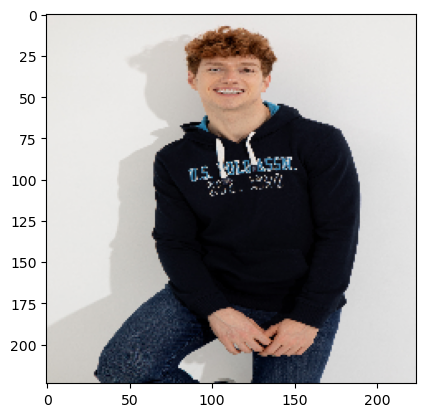

,classes,preds,actuals
0,0,0,0.0
1,1,0,0.0
2,2,1,1.0
3,3,0,0.0
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,1,1.0
0,0,1,1.0
1,1,0,0.0


In [23]:
from multioutput_eval import custom_predict
from helpers import show_image 
custom_predict(model_3, one_bathc_inputs[20], get_labels_as_array_from_batch(one_bathc_outputs, 20), classes=classes)

In [54]:
from multioutput_eval import MultiOutputModelTester
tester = MultiOutputModelTester(model_3, y_test.iloc[:, 3:], X_test["paths"].to_list()[:]) 

100 th iteration. You have 1128 inputs. 
200 th iteration. You have 1128 inputs. 
300 th iteration. You have 1128 inputs. 
400 th iteration. You have 1128 inputs. 
500 th iteration. You have 1128 inputs. 
600 th iteration. You have 1128 inputs. 
700 th iteration. You have 1128 inputs. 
800 th iteration. You have 1128 inputs. 
900 th iteration. You have 1128 inputs. 
1000 th iteration. You have 1128 inputs. 
1100 th iteration. You have 1128 inputs. 


In [61]:
falses = tester.get_falses() 
1- len(falses['YakaTipi_id']) / len(y_test), 1- len(falses['CepOzelligi_id'])/ len(y_test), 1- len(falses['KolBoyuAciklama_id'])/ len(y_test) 

(0.8484042553191489, 0.7960992907801419, 0.9317375886524822)

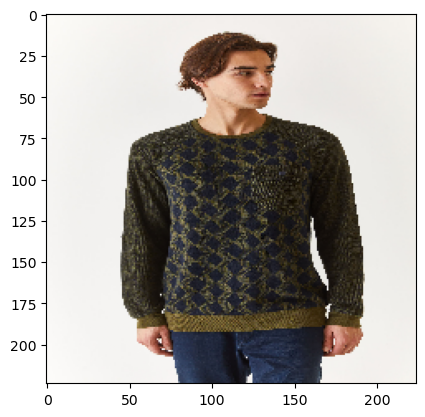

In [77]:
from helpers import show_image
import random 

show_image(falses['YakaTipi_id'][random.randint(0, 100)])